In [1]:
#import all the modules that we need for the analysis
from __future__ import print_function, absolute_import, division
#%matplotlib inline

##imports
import os
import requests
import numpy as np
import pandas as pd
#import seaborn as sb
import astropy.io.fits as pf
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator
import yaml
import emcee

#froms from standards
import astropy
from glob import glob
from astropy.wcs import WCS
from astropy.io import fits
from matplotlib import cm
from scipy.signal import medfilt
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import FormatStrFormatter

#froms from non-standards
#from astroquery.mast import Catalogs
from lightkurve import TessTargetPixelFile
#from tess_stars2px import tess_stars2px_function_entry
#from ipywidgets import interact, interactive, fixed, interact_manual
#import ipywidgets as widgets
from glob import glob

from numpy import exp, loadtxt, pi, sqrt
#from lmfit import Model
from matplotlib import rc
from astropy.modeling import models, fitting
import numpy as np
#import radvel

/Users/neisner/opt/anaconda3/envs/exoplanet/lib/python3.9/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/neisner/.lightkurve/cache. Please move all the files in the legacy directory /Users/neisner/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


In [2]:
import lightkurve as lk 

search_result = lk.search_lightcurve('TIC 470710327', author = 'SPOC').download_all().stitch()
search_result

alltime = search_result.time.value
allflux = search_result.flux.value
allerr = search_result.flux_err.value


In [3]:
period = 1.1047115
t0 = 1766.2685

period_9 = 9.9729
t0_9 = 1795.506 - (period_9 * 3)


In [4]:
section_number = 3

In [5]:
def sort_on_x(x,y):
    zipped = list(zip(x,y))
    zipped.sort(key=lambda x:x[0])
    x,y = list(zip(*zipped))
    return x,y


def run_binning(x,y,yerr=None,nbins=100,alias=False):
    # Binning function -- takes into account aliasing and error
    # propogation on errorbins
    x = np.array(x)
    y = np.array(y)
    
    finite_mask = np.isfinite(x) * np.isfinite(y)
    
    x = x[finite_mask]
    y = y[finite_mask]
    
    bwidth = 1./nbins
    if alias==True:
        phStart,phStop = -0.6,0.6
    else:
        phStart,phStop = -0.5,0.5

    bins      = np.arange(phStart,phStop+bwidth,bwidth)
    bin_means = ( np.histogram(x,bins,weights=y)[0] / np.histogram(x,bins)[0] )
    if yerr is not None:
        bin_errs = ( np.histogram(x,bins,weights=yerr)[0] / np.histogram(x,bins)[0] )
    else:
        bin_errs = None
        
    return bwidth,bins,bin_means,bin_errs


def time_to_ph(time, period=1., t0=0., pshift=0.):
    '''
    converts time to phase from input ephemeris
    DOES NOT ACCOUNT FOR BARYCENTRIC OR HELIOCENTRIC CORRECTION

    input: time (float or array)  --> time point or array
    input: period (float)
    input: t0 (float)
    input: pshift (float) --> phase shift
    ------
    output: phase (float or array)
    '''
    time = np.array(time)
    ph = np.mod((time-t0)/period, 1.0) + pshift
    ph[ph < 0.0] += 1.
    ph[ph > 0.5] -= 1.

    return ph


def interpolate_signal(x_indep,x_model,y_model,nbins):

    bin_width,bin_edges,bin_means,_ = run_binning(x_model,y_model,nbins=nbins)
    bins = bin_edges[:-1]+0.5*bin_width

    interpolated_model = PchipInterpolator(bins,bin_means,extrapolate=False)
    interpolated_y = interpolated_model(x_indep)

    return interpolated_y,interpolated_model


def model_signal(period,t0,x,y,x1=None,y1=None,nbins=100):

    ph_x = time_to_ph(x,period,t0)
    ph_x_sorted,y_sorted = sort_on_x(ph_x,y)
    y_interpolated, model = interpolate_signal(ph_x,ph_x_sorted,y_sorted,nbins)

    y_model_subtracted = y-y_interpolated

    return y_model_subtracted, y_interpolated, model


def trend_removal_interact(period_a, t0_a, times_original, flux_original, time_cut, flux_cut, nbins = 100):



    flux_cut_sub_period_a, flux_cut_period_a_model,\
    flux_cut_period_a_function = model_signal(period_a, t0_a,time_cut,flux_cut, nbins)
    
    ph_original = time_to_ph(times_original,period_a,t0_a)
    ph_cut = time_to_ph(time_cut,period_a,t0_a)
    
    flux_original_period_a_model = flux_cut_period_a_function(ph_original)
    flux_original_sub_period_a = flux_original - np.array(flux_original_period_a_model)
    
    fig,axes = plt.subplots(2,1, figsize = (7,8))
    fig.subplots_adjust(bottom=0.2)

    axes[0].plot(ph_original,flux_original,marker = '.', lw = 0, color = 'grey')
    axes[0].plot(ph_cut,flux_cut,marker = '.', lw = 0, color = 'k')
    
    axes[0].plot(ph_original,flux_original_period_a_model,marker = '.', lw = 0, color = 'darkorange', ms = 2)
    
    
    axes[1].plot(ph_original,flux_original_sub_period_a,'k.', alpha = 0.5)
    
    axes[0].set_ylabel(r'$Flux$',fontsize=18)
    axes[1].set_ylabel(r'$Flux$',fontsize=18)
    axes[1].set_xlabel(r'$\Phi$',fontsize=18)
    
    
    axes[0].tick_params(direction='in', length = 3, which ='minor', colors='grey', labelsize=13)
    axes[0].tick_params(axis="y",direction="inout") #, pad= -20)
    axes[0].tick_params(axis="x",direction="inout") #, pad= -17)   
    axes[0].tick_params(axis='both', length = 5, left='on', top='on', right='on', bottom='on')

    axes[1].tick_params(direction='in', length = 3, which ='minor', colors='grey', labelsize=13)
    axes[1].tick_params(axis="y",direction="inout") #, pad= -20)
    axes[1].tick_params(axis="x",direction="inout") #, pad= -17)   
    axes[1].tick_params(axis='both', length = 5, left='on', top='on', right='on', bottom='on')


    #plt.savefig('/Users/Nora/Documents/research/projects/fluffy/figs/sig_removal.png', dpi = 300)
    plt.show()  
    
    return ph_original,times_original, flux_original_sub_period_a, flux_original_period_a_model, ph_cut, flux_cut


In [6]:
data = {'time': search_result.time.value, 'flux': search_result.flux.value, 'err': search_result.flux_err.value}

time_cut_w9 = search_result.time.value
flux_cut_w9 = search_result.flux.value
err_cut_w9 = search_result.flux_err.value

#time_cut_w9 = data['time']
#flux_cut_w9 = data['flux']
#err_cut_w9 = data['err']

new_mask_w9 = (time_cut_w9 > 1790 ) & (time_cut_w9 < 1792) 
time_cut_w9 = time_cut_w9[~new_mask_w9]
flux_cut_w9 = flux_cut_w9[~new_mask_w9]
err_cut_w9 = err_cut_w9[~new_mask_w9]

new_mask_w9 = (time_cut_w9 > 1814 ) & (time_cut_w9 < 1815) 
time_cut_w9 = time_cut_w9[~new_mask_w9]
flux_cut_w9 = flux_cut_w9[~new_mask_w9]
err_cut_w9 = err_cut_w9[~new_mask_w9]


In [7]:

time_cut = time_cut_w9
flux_cut = flux_cut_w9
err_cut = err_cut_w9

for i in range(0,1030):
    
    mask = (time_cut > ((t0_9 + (i*period_9))-0.35)) & (time_cut < ((t0_9 + (i*period_9))+0.35))

    time_cut = time_cut[~mask]
    flux_cut = flux_cut[~mask]
    err_cut = err_cut[~mask]
    
new_mask = (time_cut > 1790 ) & (time_cut < 1792) 
time_cut = time_cut[~new_mask]
flux_cut = flux_cut[~new_mask]
err_cut = err_cut[~new_mask]

new_mask = (time_cut > 1814 ) & (time_cut < 1815) 
time_cut = time_cut[~new_mask]
flux_cut = flux_cut[~new_mask]
err_cut = err_cut[~new_mask]

#plt.figure(figsize=(10,5))
#
#plt.plot(time_cut, flux_cut, '.', color ='red')

#np.savetxt("/Users/Nora/Documents/research/projects/fluffy/fluffy_removesig/sec24_sig_rem.txt", np.array([time_cut[new_sec_mask], flux_cut[new_sec_mask], (flux_cut[new_sec_mask]/flux_cut[new_sec_mask]*0.001)]).T)

#plt.xlim(1955.4,1960)

period = period
t0 = 1766.267

#for i in range(0,1200):
#    plt.axvline(t0 + i * period, color = 'gold', alpha = 0.1)

#plt.show()


period_a = 1.104686
t0_a = 0.

good_mask = np.isfinite(np.array(data['time'])) * np.isfinite(np.array(data['flux'])) 

alltime_ar = np.array(data['time'])[good_mask]
allflux_ar = np.array(data['flux'])[good_mask]

good_mask_cut = np.isfinite(np.array(time_cut)) * np.isfinite(np.array(flux_cut)) 
good_mask_cut_w9 = np.isfinite(np.array(time_cut_w9)) * np.isfinite(np.array(flux_cut_w9)) 


alltime_ar_cut = np.array(time_cut)[good_mask_cut]
allflux_ar_cut = np.array(flux_cut)[good_mask_cut]

alltime_ar_cut_w9 = np.array(time_cut_w9)[good_mask_cut_w9]
allflux_ar_cut_w9 = np.array(flux_cut_w9)[good_mask_cut_w9]

#plt.scatter(time_cut_w9, flux_cut_w9, s = 1)



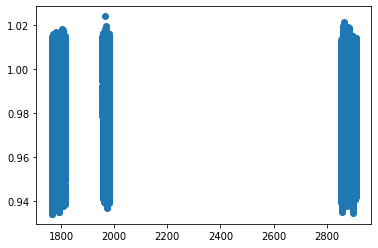

In [8]:
fig, ax = plt.subplots()

plt.scatter(alltime_ar_cut, allflux_ar_cut)

In [9]:
#cut_times = [1762, 1776.6, 1790.4, 1802.6, 1820, 1971.02, 1997.6, 2865.1, 2882.221, 2896.149, 2913.3]
cut_times = [1762, 1820, 1997.6, 2913.3]
color = ['r', 'k','r', 'k','r', 'k','r', 'k','r', 'k','r', 'k','r', 'k','r', 'k']

ph_original = []
times_original = []
flux_original_sub_period_a = []
model = []
ph_cut = []
flux_cut = []
    
#for i in range(0,len(cut_times)-1):
#fig, ax = plt.subplots()
mask = (alltime_ar_cut > cut_times[section_number]) & (alltime_ar_cut < cut_times[section_number+1])
mask_w9 = (alltime_ar_cut_w9 > cut_times[section_number]) & (alltime_ar_cut_w9 < cut_times[section_number+1])

#plt.scatter(time_cut_w9[mask], flux_cut_w9[mask],s = 0.5)
#plt.show()
alltime_ar_cut_w9_temp = alltime_ar_cut_w9[mask_w9]
allflux_ar_cut_w9_temp = allflux_ar_cut_w9[mask_w9]


alltime_ar_cut_temp = alltime_ar_cut[mask]
allflux_ar_cut_temp = allflux_ar_cut[mask]

period = 1.1047115
t0 = 1766.267

#phased = np.array([-0.5+( ( t - t0-0.5*period) % period) / period for t in alltime_ar_cut_temp])
#
#fig, ax = plt.subplots()
#
#plt.scatter(phased,allflux_ar_cut_temp, s = 2, alpha = 0.8, c = alltime_ar_cut_temp)
#
#plt.xlim(-0.15,0.15)

ph_original, times_original, flux_original_sub_period_a, model, ph_cut, flux_cut = trend_removal_interact(period_a, 0.1, alltime_ar_cut_temp, allflux_ar_cut_temp, alltime_ar_cut_temp, allflux_ar_cut_temp)

#ph_original.append(ph_original_temp)
#times_original.append(times_original_temp)
#flux_original_sub_period_a.append(flux_original_sub_period_a_temp)
#model.append(model_temp)
#ph_cut.append(ph_cut_temp)
#flux_cut.append(flux_cut_temp)

    
    
#ph_original = np.hstack(ph_original)
#times_original = np.hstack(times_original)
#flux_original_sub_period_a = np.hstack(flux_original_sub_period_a)
#model = np.hstack(model)
#ph_cut = np.hstack(ph_cut)
#flux_cut = np.hstack(flux_cut)
#    

IndexError: list index out of range

In [ ]:
# Remove the overall trend and then re do the fitting to remoe the signal to see whether we can improve on the trend removal

import filters
import norm

times_cut = times_original
flux_cut = flux_original_sub_period_a

T_dur = 5

nmed = int(30*3*T_dur)
nmed = 2*int(nmed/2)+1


ff = filters.NIF(np.array(flux_cut),nmed,10,fill=True,verbose=True)

# first number is three times transit durations, the second quite small (10,20 )
l = np.isfinite(ff)


In [ ]:
from scipy.interpolate import interp1d
g = interp1d(times_cut[l],ff[l],bounds_error=False,fill_value=np.nan)

ff = g(times_cut)
plt.figure(figsize=(10,5))
plt.plot(times_cut,flux_cut,'.')
plt.plot(times_cut,ff,'.', color = 'orange')
print(np.isfinite(ff).sum(),len(ff))


T_dur = 15

nmed = int(30*3*T_dur)
nmed = 2*int(nmed/2)+1


ff = filters.NIF(np.array(flux_cut),nmed,10,fill=True,verbose=True)

# first number is three times transit durations, the second quite small (10,20 )
l = np.isfinite(ff)

g = interp1d(times_cut[l],ff[l],bounds_error=False,fill_value=np.nan)

ff = g(times_original)


In [ ]:
plt.figure(figsize=(10,5))

#plt.plot(alltime_ar_cut,allflux_ar_cut,'.', color = 'k', ms = 1) 

print(np.isfinite(ff).sum(),len(ff))
plt.plot(times_cut,flux_cut,'.')
plt.plot(times_original,ff,'.', color = 'orange')

flux_detrended_sig_rem = flux_cut - ff
time_detrended_sig_rem = times_original

fig, ax = plt.subplots(figsize=(10,5))

#plt.plot(alltime_ar_cut_w9, allflux_ar_cut_w9,'.k', ms = 1)
plt.plot(time_detrended_sig_rem, flux_detrended_sig_rem,'.k', alpha = 1, ms = 1)



In [ ]:
#### now that it has been detrended, run the phase folding again: 
period_4 =  4.09175
t0_4 = 1765.17
# remove the 9.9d signal 


finite_mask = np.isfinite(time_detrended_sig_rem) * np.isfinite(flux_detrended_sig_rem)

time_detrended_sig_rem_finite = time_detrended_sig_rem[finite_mask]
flux_detrended_sig_rem_finite = flux_detrended_sig_rem[finite_mask]


ph_original, times_original, flux_original_sub_period_a, model, ph_cut, flux_cut = trend_removal_interact(period_4, t0_4, time_detrended_sig_rem, flux_detrended_sig_rem, time_detrended_sig_rem, flux_detrended_sig_rem, nbins = 100)

In [ ]:
#plt.figure(figsize=(10,5))
#
#plt.plot(time_detrended_sig_rem, flux_detrended_sig_rem,'.k', alpha = 1, ms = 2)
#plt.show()
#

period_4 =  4.09175
t0_4 = 1765.185

  
phased = np.array([-0.5+( ( t - t0_4-0.5*period_4) % period_4) / period_4 for t in time_detrended_sig_rem])

#phased = np.array([-0.5+( ( t - t0-0.5*period) % period) / period for t in data['time']])
print (period_4)
plt.figure(figsize=(5,5))

plt.scatter(phased, flux_detrended_sig_rem, c = time_detrended_sig_rem, s = 1)
plt.xlim(-0.1,0.1)
plt.axvline(0)
plt.show()


for i in range(0,1030):
    
    mask = (time_detrended_sig_rem > ((t0_9 + (i*period_9))-0.35)) & (time_detrended_sig_rem < ((t0_9 + (i*period_9))+0.35))

    time_detrended_sig_rem = time_detrended_sig_rem[~mask]
    flux_detrended_sig_rem = flux_detrended_sig_rem[~mask]

    
    
#np.savetxt("/Users/Nora/Documents/research/projects/fluffy/fluffy_removesig/LC_9d_4d_sig_only.txt", np.array([time_detrended_sig_rem, flux_detrended_sig_rem]).T)

In [ ]:
import statsmodels.api as sm


In [ ]:
lowess = sm.nonparametric.lowess


In [ ]:
plt.figure(figsize=(10,5))

plt.plot(ph_original, model, lw = 0, marker = '.')   
plt.show()
model_smooth = lowess(model, ph_original, return_sorted = True, frac = 0.01, it = 5)

model_smooth_x = model_smooth[:,0]
model_smooth_y = model_smooth[:,1]

gradient = np.gradient(model_smooth_y, model_smooth_x)



In [ ]:
gradient_smooth0 = lowess(gradient, model_smooth_x,return_sorted = True, frac = 0.01, it = 5)

gradient_smooth0_x = gradient_smooth0[:,0]
gradient_smooth0_y = gradient_smooth0[:,1]

gradient_smooth = lowess(gradient_smooth0_y, gradient_smooth0_x,return_sorted = True, frac = 0.01, it = 5)

gradient_smooth_x = gradient_smooth[:,0]
gradient_smooth_y = gradient_smooth[:,1]


In [ ]:
fig,ax = plt.subplots(2,1, figsize = (7,6), sharex = True)

ax[0].plot(model_smooth_x, gradient, lw = 0, marker = '.', ms = 1)
ax[0].plot(gradient_smooth_x, gradient_smooth_y, lw = 0, marker = '.', ms = 1)

derif2 = np.gradient(gradient_smooth_y, gradient_smooth_x)

derif2_smooth = lowess(derif2, gradient_smooth_x, return_sorted = True, frac = 0.01, it = 5)

derif2_smooth_x = derif2_smooth[:,0]
derif2_smooth_y = derif2_smooth[:,1]

ax[1].plot(gradient_smooth_x, derif2, lw = 0, marker = '.', ms = 1)
ax[1].plot(derif2_smooth_x, derif2_smooth_y, lw = 0, marker = '.', ms = 1)

plt.show()

In [ ]:
import yaml  
import emcee

In [ ]:
def log_prior(theta):
    alpha0, alpha1, t0, d, Tau = theta
    
    if  (0 < alpha0 < 10) and ( -10 < alpha1 < 0) and (-0.5 < t0 < 0.5) and (0 < d < 10) and (0.5 < Tau < 50):
        return 0.0
    return -np.inf


def log_likelihood(theta, x, y, yerr):
    
    alpha0, alpha1, t0, d, Tau = theta
    
    cosh_term = np.cosh( (x - t0) /d )
    exp_term = np.exp(1 - cosh_term)
    pow_term = pow((1 - exp_term), Tau)
    
    psi = 1 - pow_term
    
    model = alpha0 + (alpha1 * psi)
    
    return -0.5 * np.sum((y - model) ** 2 / (yerr ** 2) )


def log_probability(theta, x, y, yerr):
    
    # check that the priors are satisfied
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)


def get_starting_positions(start_vals, nwalkers=128):

    p0 = np.array( [ [ val+1e-5*np.random.randn()
                       for jj,val in enumerate(start_vals) ]
                      for i in range(nwalkers) ] )
    
    yield p0


In [ ]:
print(len(ph_original), len(times_original), len(flux_original_sub_period_a), len(model), len(ph_cut), len(flux_cut))



fig, ax = plt.subplots(figsize=(10,5))

plt.plot(ph_cut,flux_cut,',k')
plt.axvline(0)
plt.show()


In [ ]:
np.nanmean(err_cut)

In [ ]:
# for primary 
def prepare_data_elcipse(time, phase, flux, err, start_ph, end_ph):

    df = pd.DataFrame({'time':time,'phase':phase, 'flux':flux, 'err':err})
    
    df_in_phase = df[(df['phase'] > start_ph) & (df['phase'] < end_ph) ]
    
    return df_in_phase


# time_detrended_sig_rem, flux_detrended_sig_rem
df_in_phase = prepare_data_elcipse(times_original, ph_cut, flux_cut, len(flux_cut) * [0.0007], -0.03, 0.03) #-0.315, -0.0863)        
    
ph_primary0  = df_in_phase.phase
flux_primary0 = df_in_phase.flux + 1
err_primary0 = df_in_phase.err

def run_binning(x0,y0,period=1.,yerr=None,nbins=100):
    # Binning function -- takes into account aliasing and error
    # Propogation on errorbins
    x = np.array(x0)
    y = np.array(y0)
    
    finite_mask = np.isfinite(x) * np.isfinite(y)
    
    x = x[finite_mask]
    y = y[finite_mask]
    
    yerr = yerr[finite_mask]
    
    bwidth = 1./nbins
    
    phStart,phStop = np.nanmin(x), np.nanmax(x)

    bins      = np.arange(phStart,phStop+bwidth,bwidth)
    
    bin_means = ( np.histogram(x,bins,weights=y)[0] / np.histogram(x,bins)[0] )
    if yerr is not None:
        bin_errs = ( np.histogram(x,bins,weights=yerr)[0] / np.histogram(x,bins)[0] )
    else:
        bin_errs = None
    
    bins =  bins[:-1] + 0.5*bwidth
    
    return bins,bin_means,bin_errs

# period_4, t0_

ph_binned,flux_binned,err_binned = run_binning(ph_primary0,flux_primary0,period_4,yerr=err_primary0,nbins=3000)

fig = plt.subplots(figsize=(10, 4), sharex=True)

plt.errorbar(ph_binned, flux_binned, yerr=err_binned, fmt=".k", capsize=0, zorder = 2)
plt.scatter(ph_primary0, flux_primary0, zorder = -2)

ph_primary = ph_primary0 #ph_binned
flux_primary = flux_primary0#flux_binned
err_primary = err_primary0#err_binned


In [ ]:
# alpha0 + alpha1 * (1 - ( 1 - np.exp( 1 - np.cosh( (x - t0)/ d ))))**Tau

def model_fit(x, alpha0, alpha1, t0, d, Tau):
    
    cosh_term = np.cosh( (x - t0) /d )
    exp_term = np.exp(1 - cosh_term)
    pow_term = pow((1 - exp_term), Tau)
    
    psi = 1 - pow_term
    
    model = alpha0 + (alpha1 * psi)
    
    return model 


In [ ]:
fig = plt.subplots(figsize=(10, 3), sharex=True)

#alpha0, alpha1, t0, d, Tau


plt.errorbar(ph_primary, flux_primary, yerr=err_primary, fmt=".k", capsize=0, zorder = -2)

plt.plot(ph_primary, model_fit(ph_primary, 1, -0.005, 0.001, 0.012, 1.5), lw = 0, marker = '.', markersize = 0.5, alpha=1, zorder = 2, color= 'red')



In [ ]:
start_vals = [1, -0.005, 0.001, 0.012, 1.5]


pos = list(get_starting_positions(start_vals,nwalkers=128))[0]

nwalkers = 128
ndim = len(start_vals)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(ph_primary, flux_primary, err_primary))

sampler.run_mcmc(pos, 1000, progress=True)

In [ ]:
tau = sampler.get_autocorr_time(tol=0)
print (tau)

In [ ]:
fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)

samples = sampler.get_chain()
labels = ["alpha0", "alpha1", "t0", "d", "Tau"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [ ]:
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
print(flat_samples.shape)

In [ ]:
fig = plt.subplots(figsize=(10, 3), sharex=True)


mean_alpha0 = np.median(flat_samples[:,0])
mean_alpha1 = np.median(flat_samples[:,1])
mean_t0 = np.median(flat_samples[:,2])
mean_d = np.median(flat_samples[:,3])
mean_Tau = np.median(flat_samples[:,4])

print(mean_alpha0)
print(mean_alpha1)
print(mean_t0)
print(mean_d)
print(mean_Tau)

inds = np.random.randint(len(flat_samples), size=1000)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(ph_primary, model_fit(ph_primary, sample[0], sample[1], sample[2], sample[3], sample[4]), "C1", lw = 0, marker = '.',alpha=0.1, zorder = 2)

plt.errorbar(ph_primary, flux_primary, yerr=err_primary, fmt=".k", capsize=0, zorder = -2)

plt.plot(ph_primary, model_fit(ph_primary, mean_alpha0, mean_alpha1,mean_t0, mean_d, mean_Tau), lw = 0, marker = '.', markersize = 0.5, alpha=1, zorder = 2, color= 'red')

plt.xlabel("x")
plt.ylabel("y");

In [ ]:
#mean_alpha0 = 1.0000253863402706
#mean_alpha1 = -0.0047875865148671055
#mean_t0 = 0.0016515232968323313
#
#mean_d = 0.014372813842957043
#mean_Tau = 1.084475152646608


# now that we have the best fit model, we fit this model to each individual eclipse using mcmc
# the free parameters are t0, alpha0 and alpha1, the rest are fixed by phase folded model

def log_prior_fitting(theta):
    alpha0, alpha1, t0 = theta
    #0.998, -0.003, 0.001, 0.009, 1.2
    if  (0 < alpha0 < 2) and ( -0.01 < alpha1 < -0.00047) and (-0.5 < t0 < 0.5):
        return 0.0
    return -np.inf


def log_likelihood_fitting(theta, x, y, yerr):
    
    alpha0, alpha1, t0 = theta
        
    cosh_term = np.cosh( (x - t0) /mean_d )
    exp_term = np.exp(1 - cosh_term)
    pow_term = pow((1 - exp_term), mean_Tau)
    
    psi = 1 - pow_term
    
    model = alpha0 + (alpha1 * psi)
    
    
    return -0.5 * np.sum((y - model) ** 2 / (yerr ** 2) )

def log_probability_fitting(theta, x, y, yerr):
    
    # check that the priors are satisfied
    lp = log_prior_fitting(theta)
    if not np.isfinite(lp):
        return -np.inf
    lnp = lp + log_likelihood_fitting(theta, x, y, yerr)

    return lnp


def get_starting_positions_fitting(start_vals, nwalkers=128):

    p0 = np.array( [ [ val+1e-5*np.random.randn()
                       for jj,val in enumerate(start_vals) ]
                      for i in range(nwalkers) ] )
    
    yield p0


In [ ]:
time_primary  = df_in_phase.time
ph_primary  = df_in_phase.phase
flux_primary = df_in_phase.flux
err_primary = df_in_phase.err

In [ ]:
from os.path import basename, exists
import sys 
import csv

tr_index = range(-100,1000)

outfile_path = '/Users/neisner/Documents/projects/fluffy/reanalysed/mcmc_etvs_4d_{}.csv'.format(section_number)

if exists('{}'.format(outfile_path)):
    print("Existing manifest file found, will skip previously processed LCs and append to end of manifest file")
    sys.stdout.flush()

else:
    print("Creating new manifest file")
    sys.stdout.flush()
    
    metadata_header = ["number", 'epoch', 't0', 'alpha1', 'alpha2', 'd', 'Tau']
          
    with open('{}'.format(outfile_path), 'w') as f: # save in the photometry folder
        writer = csv.writer(f, delimiter=',')
        writer.writerow(metadata_header)

manifest_table = pd.read_csv('{}'.format(outfile_path))

number_done = manifest_table['number']

for i in tr_index:
    if not np.isin(i,number_done):
        
        transit_time = t0_4+(period_4*i)
        
        x = np.array(time_primary)
        y = np.array(flux_primary) + 1
        yerr = np.array(err_primary)
        
        mask = (x > (transit_time - (0.5*period_4))) & (x < (transit_time + (0.5*period_4))) 
        
        x = np.array(x[mask])
        y = np.array(y[mask])
        yerr = np.array(yerr[mask])

        finite_mask = np.isfinite(x) * np.isfinite(y)
        
        x = np.array(x[finite_mask])
        y = np.array(y[finite_mask])
        yerr = np.array(yerr[finite_mask])
        
        x = np.array([-0.5+( ( t - t0_4-0.5*period_4) % period_4) / period_4 for t in x])
        
        if len(x) > 20:

            start_vals = [mean_alpha0, mean_alpha1, mean_t0]
    
            pos = list(get_starting_positions(start_vals,nwalkers=64))[0]
            
            nwalkers = 64
            ndim = len(start_vals)
            
            # start the mcmc fitting
            sampler2 = emcee.EnsembleSampler(nwalkers, ndim, log_probability_fitting, args=(x, y, yerr))
            
            sampler2.run_mcmc(pos, 1000, progress=True)
    
            flat_samples2 = sampler2.get_chain(discard=200, thin=15, flat=True)
            
            mean_alpha0_fit = np.nanmedian(flat_samples2[:,0])
            mean_alpha1_fit = np.nanmedian(flat_samples2[:,1])
            mean_t0_fit = np.nanmedian(flat_samples2[:,2])
    
              
            fig = plt.subplots(figsize=(10, 3), sharex=True)
            
            plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0, zorder = -2)
            plt.plot(x, model_fit(x, mean_alpha0_fit, mean_alpha1_fit,mean_t0_fit, mean_d, mean_Tau), lw = 1, marker = '.', markersize = 0.5, alpha=1, zorder = 2, color= 'red')
    
            plt.show()
              
            with open('{}'.format(outfile_path), 'a') as f: # save in the photometry folder
                writer = csv.writer(f, delimiter=',')
                writer.writerow([i, transit_time, mean_t0_fit, mean_alpha0_fit, mean_alpha1_fit, mean_d, mean_Tau])
        else:
            print ("not enough data -- skip")
    else:
        print ("Number {} has already been completed -- skip".format(i))
        


In [ ]:
in_df = pd.read_csv('/Users/neisner/Documents/projects/fluffy/reanalysed/mcmc_etvs_4d_3.csv')

In [ ]:
#### now that it has been detrended, run the phase folding again: 
period_4 =  4.09175
t0_4 = 1765.17

in_df['midpoint'] = in_df['epoch'] + (in_df['t0']*period_4)
in_df['shift_mins'] = in_df['t0']*period_4*24*60

fig = plt.subplots(figsize=(10, 3), sharex=True)

plt.scatter(in_df['epoch'], in_df['shift_mins'])
#plt.ylim(-5,15)
plt.show()


In [ ]:
np.linspace(50,150,50)

In [ ]:
period = 52.992

#for period in np.linspace(50,150,50):
t0 = 1781.64
print (period)

fig, ax = plt.subplots()

phased = np.array([-0.5+( ( t - t0-0.5*period) % period) / period for t in in_df['epoch']])

plt.scatter(phased,in_df['shift_mins'], s =40, alpha = 1, c = in_df['epoch'])

plt.show()
plt.xlim(-0.5,0.5)

In [ ]:
%matplotlib notebook

fig, ax = plt.subplots()

plt.scatter(in_df['epoch'] - 1781.64,in_df['shift_mins'], s =40, alpha = 1)


period = 52 # 109.18367346938776

print (period)
freq= 1/period


#xstretch = 0.2
yshift = -0.8
phase = np.pi+1.5

x = np.linspace (np.min(in_df['epoch']),np.max(in_df['epoch']) + 0 , 2000) - 1781.66
y = 400*(np.sin(2*np.pi * freq * x + phase)) + yshift

plt.plot(x,y, alpha = 0.4, color = 'grey')


#plt.xlim(-0.1,0.1)
#plt.xlim(2800,3000)